# WDNN Example 01 - Wine Price Prediction 

Using the `keras` functional API to build a wide and deep neural netwrk (WDNN) that can predict the price of a wine using its description and variety. 

Trained using [Kaggle's Wine Reviews](https://www.kaggle.com/zynicide/wine-reviews/data) dataset as described in [this blog post](https://blog.tensorflow.org/2018/04/predicting-price-of-wine-with-keras-api-tensorflow.html) by Sara Robinson.

## Theory 
The author notes that WDNNs are suitable for problems in which
1. There is **no relatively direct relationship between inputs and outputs**. 
  - For instance, wines with the word 'fruity' in their description are not necessarily more expensive. 
  - This is where the deep neural network component of the WDNN shines. It is able to extract unexpected relationships between IOs.
  - For the deep component, reviews should be condensed to low-dimensional embeddings that are then learned during training.
2. **Feature vectors are sparse**
  - This means that input vectors consist mostly of zero values. 
  - This is usually the case in text-based input vectors, where a sequence of words can be converted to a high-dimensional, sparse vector based on a bag of words model.

Recommender systems and models with text inputs are good use cases for WDNNs.

# Imports

In [5]:
# Standard imports
import numpy as np
import pandas as pd 

# For file and directory manipulation
import os 

# For converting categorical varieties to numerical ones
from sklearn.preprocessing import LabelEncoder 

# For building the neural network
import tensorflow as tf
from tensorflow import keras
layers = keras.layers

# Original tutorial used TensorFlow v1.7. We're using 2.2.0
print("TensorFlow verson", tf.__version__)

TensorFlow verson 2.2.0-rc2


# Preparing Data
- There are lots of features in the original dataset.
- For simplicity, we're going to use only the `description` and `variety`.
- The target is the `price` of the wine. **bold text**

## Downloading Data

Runs a shell command to get the dataset from the web. 

In [0]:
!wget -q https://storage.googleapis.com/sara-cloud-ml/wine_data.csv

Confirming that the data has been downloaded to the current working directory.

In [7]:
!ls wine_data.csv

wine_data.csv


## Reading Data

In [0]:
data = pd.read_csv('./wine_data.csv')

In [9]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


## Shuffle The Dataset

In [10]:
# Randomly sample the entire dataset: frac=1 means get a new sample of the same size as the original data
data = data.sample(frac=1)

# Did shuffling work?
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
35243,35243,Italy,"This fabulous blend of Cabernet Sauvignon, Mer...",Giusto di Notri,95,80.0,Tuscany,Toscana,NaN,Red Blend,Tua Rita
149361,149362,Australia,This Chard relies heavily on oak to get its me...,NaN,86,18.0,Western Australia,Western Australia,NaN,Chardonnay,West Cape Howe
32929,32929,Italy,Spelt is a mature and richly extracted Montepu...,Spelt,90,20.0,Central Italy,Montepulciano d'Abruzzo,NaN,Montepulciano,La Valentina
23700,23700,Argentina,"Smells different than most, with blueberry, ca...",NaN,83,15.0,Mendoza Province,Mendoza,NaN,Malbec,Manos Negras
102458,102458,US,"This is a dry, full-bodied blend of unidentifi...",Cuvée Iris,88,22.0,California,Sonoma County,Sonoma,Red Blend,Kokomo


## Eliminating Missing Values 

In [0]:
# Get all rows where the `country` column is not null
data = data[pd.notnull(data['country'])]

# Within this dataset, only retain rows where the `price` is not null
data = data[pd.notnull(data['price'])]

# Drop the first column: redundant index
data = data.drop(data.columns[0], axis=1)

In [12]:
# Did it work?
data.describe()

,points,price
count,137229.000000,137229.000000
mean,87.788033,33.131896
std,3.221583,36.323176
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,24.000000
75%,90.000000,40.000000
max,100.000000,2300.000000


## Eliminating Wine Varieties

For simplicity, we are considering only the 40 most frequently occuring wine varieties from the total 632 varieties in the original dataset.



In [0]:
# Any wine variety that occurs less than 500 times will be removed 
variety_threshold = 500

# Get number of times each variety string occurs in the variety column
value_counts = data['variety'].value_counts()

# The names of wine varieties to remove: all less than 500 occurrences
to_remove = value_counts[value_counts <= variety_threshold].index

# Replace these wine varieties with `nan` so that they can be dropped easily
data.replace(to_remove, np.nan, inplace=True)

# Retain rows with non-null value in variety column: i.e. rows with variety > 500 occurrences
data = data[pd.notnull(data['variety'])]

## Train-Test Spli

In [14]:
# The first 80% of samples will be training data
train_size = int(len(data) * .8)

# How many samples in the train and test set this way?
print("Train Size: %d" % train_size)
print("Test Size: %d" % (len(data) - train_size))

Train Size: 95646
Test Size: 23912


In [0]:
# Indexing to extract training features
description_train = data['description'][:train_size]
variety_train = data['variety'][:train_size]

# Indexing to extract training labels
labels_train = data['price'][:train_size]

In [0]:
# Indexing to extract test features
description_test = data['description'][train_size:]
variety_test = data['variety'][train_size:]

# Indexing to extract test labels
labels_test = data['price'][train_size:]

# Building the Model

## Part 1 - Wide Component

- Wide NNs are great at extracting direct relationships between inputs and outputs.
- This is especially true for sparse inputs: inputs in which most elements are 0.
- Will use a **bag of words model** for converting each description into a sparse feature vector. 
  - Find all unique words that appear in all descriptions. This is `n`.
  - Then each feature vector will be an `n`-dimensional vector which
    - is 1 when the word at index `i` is present in the description
    - is 0 when the word at index `i` is **not** present in the description.
  - For simplicity, limiting `n` to 12k: the 12k most commonly occurring words only.
  - So each feature vector will be 12,000-dimensional vector. 

### Feature 1 - Bag of Words 

In [0]:
# Look for the 12k most commonly occurring words across all descriptions
vocab_size = 12000

# Instantiate a keras Tokenizer to do this: look at unique words, not characters
tokenize = keras.preprocessing.text.Tokenizer(num_words=vocab_size, char_level=False)

# Fit it to the training descriptions only.
tokenize.fit_on_texts(description_train)

We don't fit the `Tokenizer` to test set, because we want to construct a vocabulary of 12k commonly occurring words from only the training set. 

`texts_to_matrix` will now use the 12k words found in training to convert each description to a 12k-dimensional vector as described above. 

The words found in the training data are also assumed to exist in the test data. This shows that an underlying assumption: we expect the test data to come from roughly the same distribution as the training data. Alternatively, we expect the training data to come from a distribution that is large enough to accommodate the words in the test distribution.

In [0]:
# Create matrices: `bow` means 'bag of words'. Each row in each matrix is 12k dimensional vector
description_bow_train = tokenize.texts_to_matrix(description_train)

In [0]:
# Do the same for the test data
description_bow_test = tokenize.texts_to_matrix(description_test)

### Feature 2 - Variety

In the original dataset, there are ~630 varieties of wine. For simplicity, the tutorial will consider only the 40 most commonly occurring varieties. 

Since these varieties are names such as 'Pinot Noir', we must convert them from label strings to numbered indices that can be used with a neural network.

In [0]:
# Use sklearn utility to convert label strings to numbered index

# Instantiate a label encoder
encoder = LabelEncoder()

# Fit it to the training set varieties: learn categorical variables for each category string
encoder.fit(variety_train)

# Change each label string to a number in both training and test data
variety_train = encoder.transform(variety_train)
variety_test = encoder.transform(variety_test)

# Varieties are numbered from 0 to K - 1, where K is the number of distinct labels
num_classes = np.max(variety_train) + 1

In [0]:
# To eliminate effects of ordinality in labels, convert them to one-hot encoded vectors
variety_train = keras.utils.to_categorical(variety_train, num_classes)
variety_test = keras.utils.to_categorical(variety_test, num_classes)

### Constructing the Wide Component 

Using the functional API, in which layers in a neural network are actually functions. We can pass tensors to these layers as we would pass arguments to a function, and then receive new tensors just like we would receive outputs from a function. 

Layers can be shared between different parts of the same model, and linked together in an acyclic graph by `keras. 

Taken together, a sequence of layers represents a transformation from X $\rightarrow$ Y.

In [0]:
# `Input` tensor for the wide component: sparse, 12k-dimensional word vectors
bow_inputs = layers.Input(shape=(vocab_size, ), name='wide_bow')   # (k, ) = An arbitrary number of samples

# `Input` tensor of variety labels for the wide component: multi-input model 
variety_inputs = layers.Input(shape=(num_classes, ), name='wide_variety')

# Two different inputs will then be concatenated 
merged_layer = layers.concatenate([bow_inputs, variety_inputs])

# Densely connected classifier will process merged inputs
merged_layer = layers.Dense(256, activation='relu')(merged_layer)

# Linear unit will output continuous value - price of the wine
predictions = layers.Dense(1)(merged_layer)

In [0]:
# Combine this sequence of transformations into an acyclic graph
wide_model = keras.Model(inputs=[bow_inputs, variety_inputs], outputs=predictions)

In [0]:
# Specify metrics for the wide model
"""
- loss is mean squared error since we're predicting a continuous valued output.
- optimizer is adam: combines momentum with rmsprop - fewer oscillations, updates based on magnitude of moving average of gradients
- metric is accuracy: accuracy of what?
"""
wide_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

### Wide Model Summary

In [25]:
# What does the wide model look like?
print(wide_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wide_bow (InputLayer)           [(None, 12000)]      0                                            
__________________________________________________________________________________________________
wide_variety (InputLayer)       [(None, 40)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 12040)        0           wide_bow[0][0]                   
                                                                 wide_variety[0][0]               
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          3082496     concatenate[0][0]            

## Part 2 - Deep Component

The deep component will process wine descriptions as embeddings: dense numerical vectors to which specific sequences of words have been mapped. 

No need for sparse vectors in a deep neural network because unlike the wide NN, it works better with dense input features. 

Dense embeddings reduce number of parameters, and can also be learned during training. 

The deep component will not use the variety of the wine as a feature.

### Feature 1 - Word Embeddings

Instead of converting each description to a 12k-dimensional one-hot encoded vectors (as in the case of `texts_to_matrix`), we are going to convert each description to a sequence of numbers: not necessarily ones or zeros. 

A bag of words model is created. Each unique word in each description is assigned a unique integer from 0 to `n`, where `n - 1` is the total number of unique words in all descriptions. 

This is different from text_to_matrix because it does not one-hot encode sequences. 



In [0]:
train_embed = tokenize.texts_to_sequences(description_train)
test_embed = tokenize.texts_to_sequences(description_test)

Each word in each description has been tokenized i.e. converted to one of `n` different integers. 

However, because this isn't one-hot encoding, each sequence of numbers is of different length. We want all descriptions to be of the same length so they can be fed into a neural network. 

We're definining an arbitrary sequence length of 170: each description will be limited to 170 words. Any sequences with more than 170 words will be truncated, and any sequences with fewer than 170 words will have 0s appended to them (after the last number of the sequence) to bring their length to 170.

In [0]:
max_seq_length = 170 

# Create a 170-dimensional embedding vector for training data
train_embed = keras.preprocessing.sequence.pad_sequences(train_embed, 
                                                         maxlen=max_seq_length, 
                                                         padding='post')

# Do the same for the test data
test_embed = keras.preprocessing.sequence.pad_sequences(test_embed, 
                                                        maxlen=max_seq_length, 
                                                        padding='post')

### Constructing the Deep Component

In [0]:
# Input tensor is a collection of 170-dimensional vectors
deep_inputs = layers.Input(shape=(max_seq_length, ))

# First layer condenses 170-dimensional sequences to 8-dimensional representations
embedding = layers.Embedding(vocab_size, 8, input_length=max_seq_length)(deep_inputs)

# Next layer flattens the 8-dimensional data to connect to Dense layer
embedding = layers.Flatten()(embedding)

# Output of the deep model is once again a linear unit to output price
embed_out = layers.Dense(1)(embedding)

In [0]:
# Combine these layers and tensor operations into a Model
deep_model = keras.Model(inputs=deep_inputs, outputs=embed_out)

In [0]:
# Compile
deep_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

### Deep Model Summary

In [31]:
# What does the deep component look like?
print(deep_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 170)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 170, 8)            96000     
_________________________________________________________________
flatten (Flatten)            (None, 1360)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1361      
Total params: 97,361
Trainable params: 97,361
Non-trainable params: 0
_________________________________________________________________
None


It has significantly fewer parameters than the wide component, which makes sense because we've restricted the input to be a 170-dimensional vector which is further condensed t 8-dimensional during forward propagation.

In comparison, the wide network had 12k-dimensional inputs (descriptions) and another 40-dimensional input for category.

## Part 3 - Wide and Deep

Now we need to combine our submodels into a single model by concatenating their outputs, and then adding another layer that maps these concatenated outputs to a single value - the price of the wine. 

In [0]:
# Combining outputs of wide and deep models
merged_out = layers.concatenate([wide_model.output, deep_model.output])

# Adding another linear unit 
merged_out = layers.Dense(1)(merged_out)

# Create a wide and deep model
combined_model = keras.Model(wide_model.input + [deep_model.input], 
                       merged_out)

In [0]:
# Compile it with same settings as constituents 
combined_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

### Model Summary

In [34]:
# What does the wide and deep model look like?
print(combined_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wide_bow (InputLayer)           [(None, 12000)]      0                                            
__________________________________________________________________________________________________
wide_variety (InputLayer)       [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 170)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 12040)        0           wide_bow[0][0]                   
                                                                 wide_variety[0][0]         

### Training

In [35]:
wdnn_history = combined_model.fit([description_bow_train, variety_train] + [train_embed], 
                   labels_train, 
                   epochs=10, 
                   batch_size=128)

Epoch 1/10
748/748 [==============================] - 5s 7ms/step - loss: 1083.4337 - accuracy: 0.0000e+00
Epoch 2/10
748/748 [==============================] - 5s 7ms/step - loss: 843.6837 - accuracy: 0.0000e+00
Epoch 3/10
748/748 [==============================] - 5s 7ms/step - loss: 706.2977 - accuracy: 0.0000e+00
Epoch 4/10
748/748 [==============================] - 5s 7ms/step - loss: 578.8711 - accuracy: 0.0000e+00
Epoch 5/10
748/748 [==============================] - 5s 7ms/step - loss: 461.7855 - accuracy: 0.0000e+00
Epoch 6/10
748/748 [==============================] - 5s 7ms/step - loss: 355.4139 - accuracy: 0.0000e+00
Epoch 7/10
748/748 [==============================] - 6s 7ms/step - loss: 266.5933 - accuracy: 0.0000e+00
Epoch 8/10
748/748 [==============================] - 6s 8ms/step - loss: 199.4175 - accuracy: 0.0000e+00
Epoch 9/10
748/748 [==============================] - 5s 7ms/step - loss: 150.3047 - accuracy: 0.0000e+00
Epoch 10/10
748/748 [========================

## Training History

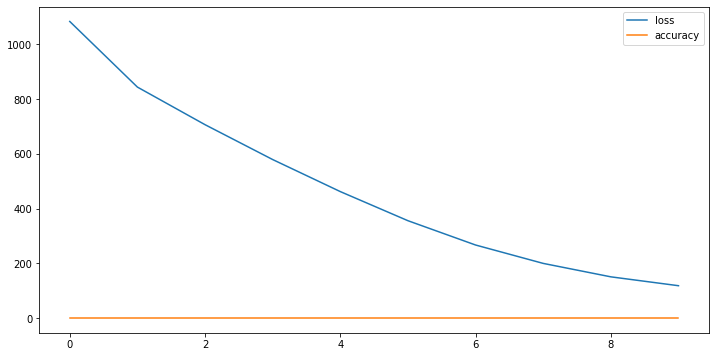

In [41]:
pd.DataFrame(wdnn_history.history).plot(figsize=(12, 6))

## Evaluating Model

In [34]:
combined_model.evaluate([description_bow_test, variety_test] + [test_embed], 
                        labels_test, 
                        batch_size=128)

187/187 [==============================] - 1s 4ms/step - loss: 514.1050 - accuracy: 0.0000e+00


[514.1050415039062, 0.0]

## Predictions

Will print actual descriptions and varieties for some examples from the training set along with their predicted price and actual price. 

This will help us get a feel for how the model is performing.

In [0]:
predictions = combined_model.predict([description_bow_test, variety_test] + [test_embed])

In [37]:
# Compare predictions wth actual values for the first few items in our dataset
num_predictions = 40 

# Used to keep a running sum of the prediction error 
diff = 0

for i in range(num_predictions):
  val = predictions[i]
  print(description_test.iloc[i])
  print("Predicted:", val[0], "Actual:", labels_test.iloc[i], '\n')

  # Update the running sum of difference between predicted and actual cost
  diff += abs(val[0] - labels_test.iloc[i])

This is an earthier, less overtly fruity rendition of McLaren Vale Shiraz, but one that still has plenty of merit. It's reasonably round and supple in texture, with flavors of black olive that coat the mouth and persist nicely on the finish.
Predicted: 26.260443 Actual: 20.0 

Notes of hay, pollen and beeswax add a savory, honeyed tone to this exquisitely dainty Riesling. The palate is intensely packed with sweet citrus fruit, but it's balanced with striking acidity and a shower of minerality on the finish.
Predicted: 70.51112 Actual: 83.0 

Pale salmon color and slightly bricked, this wine displays aromas of geranium, dried herbs and strawberry. It drinks off dry, with lightly spritzy herb flavors.
Predicted: 20.423956 Actual: 16.0 

Fresh cut pear fruit flavors carry this wine. It's crisp and clean, with fresh fruit balanced against natural acidity. Drink it now while the freshness is paramount.
Predicted: 13.142658 Actual: 15.0 

This lovely brut offers real Champagne-like finesse. 

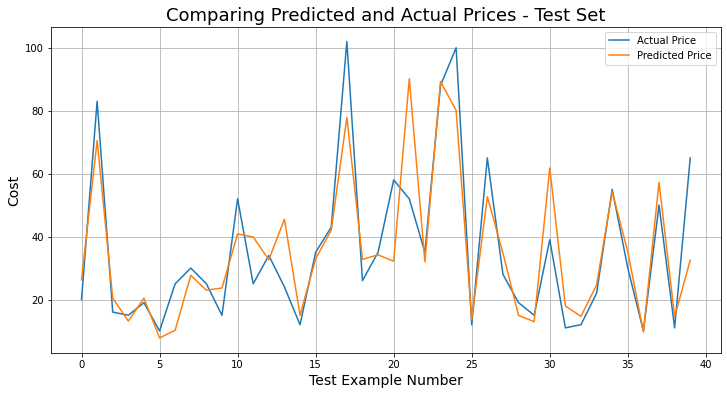

In [40]:
# It might be more useful to plot the two prices on a graph
import matplotlib.pyplot as plt 
NUM_SAMPLES = 40

plt.figure(figsize=(12, 6))
plt.plot(list(range(len(labels_test[:NUM_SAMPLES]))), labels_test[:NUM_SAMPLES], 
         label='Actual Price')
plt.plot(list(range(len(predictions[:NUM_SAMPLES]))), predictions[:NUM_SAMPLES], 
         label='Predicted Price')
plt.xlabel('Test Example Number', fontsize=14)
plt.ylabel('Cost', fontsize=14)
plt.title('Comparing Predicted and Actual Prices - Test Set', fontsize=18)
plt.grid()
plt.legend()

# Comparing with Standalone Networks

The real question is whether or not the use of a wide and deep neural network actually improve on the results obtained from either a standalone wide or deep neural network. 

I will train the wide and deep models using the same hyperparameters and compare their loss with that of the WDNN.

## Wide Network

In [28]:
wide_history = wide_model.fit([description_bow_train, variety_train], labels_train,
                              epochs=10, 
                              batch_size=128)

Epoch 1/10
748/748 [==============================] - 4s 5ms/step - loss: 1186.3929 - accuracy: 0.0000e+00
Epoch 2/10
748/748 [==============================] - 4s 5ms/step - loss: 956.0668 - accuracy: 0.0000e+00
Epoch 3/10
748/748 [==============================] - 4s 5ms/step - loss: 850.3281 - accuracy: 0.0000e+00
Epoch 4/10
748/748 [==============================] - 4s 5ms/step - loss: 760.5903 - accuracy: 0.0000e+00
Epoch 5/10
748/748 [==============================] - 4s 5ms/step - loss: 679.2787 - accuracy: 0.0000e+00
Epoch 6/10
748/748 [==============================] - 4s 5ms/step - loss: 602.5382 - accuracy: 0.0000e+00
Epoch 7/10
748/748 [==============================] - 4s 5ms/step - loss: 528.3565 - accuracy: 0.0000e+00
Epoch 8/10
748/748 [==============================] - 4s 5ms/step - loss: 459.0305 - accuracy: 0.0000e+00
Epoch 9/10
748/748 [==============================] - 4s 5ms/step - loss: 396.0287 - accuracy: 0.0000e+00
Epoch 10/10
748/748 [========================

## Deep Network

In [30]:
deep_history = deep_model.fit([train_embed], labels_train, 
                              epochs=10, 
                              batch_size=128)

Epoch 1/10
748/748 [==============================] - 4s 5ms/step - loss: 1446.2074 - accuracy: 0.0000e+00
Epoch 2/10
748/748 [==============================] - 4s 5ms/step - loss: 1156.3501 - accuracy: 0.0000e+00
Epoch 3/10
748/748 [==============================] - 4s 5ms/step - loss: 1090.9279 - accuracy: 0.0000e+00
Epoch 4/10
748/748 [==============================] - 4s 5ms/step - loss: 1050.1217 - accuracy: 0.0000e+00
Epoch 5/10
748/748 [==============================] - 4s 5ms/step - loss: 1020.8936 - accuracy: 0.0000e+00
Epoch 6/10
748/748 [==============================] - 4s 5ms/step - loss: 997.8959 - accuracy: 0.0000e+00
Epoch 7/10
748/748 [==============================] - 4s 5ms/step - loss: 978.8176 - accuracy: 0.0000e+00
Epoch 8/10
748/748 [==============================] - 4s 5ms/step - loss: 963.4370 - accuracy: 0.0000e+00
Epoch 9/10
748/748 [==============================] - 4s 5ms/step - loss: 947.8560 - accuracy: 0.0000e+00
Epoch 10/10
748/748 [====================

## Visualizing Losses

### Write History

In [0]:
# Wrote history to Drive because RAM limit meant could not train WDNN, WNN, and DNN in one session
import pickle 

with open('./wideHistory.pickle', 'wb') as file_pickle:
  pickle.dump(wide_history.history, file_pickle)

with open('./deepHistory.pickle', 'wb') as file_pickle:
  pickle.dump(deep_history.history, file_pickle)

### Read History

In [0]:
# Loading wide and deep histories
import pickle

with open('./deepHistory.pickle', 'rb') as history:
  deep_history = pickle.load(history)

with open('./wideHistory.pickle', 'rb') as history:
  wide_history = pickle.load(history)

### Preparing Plotting Data

In [0]:
epochs = list(range(10))
wide_loss = wide_history['loss']
deep_loss = deep_history['loss']
wide_deep_loss = wdnn_history.history['loss']

### Plot

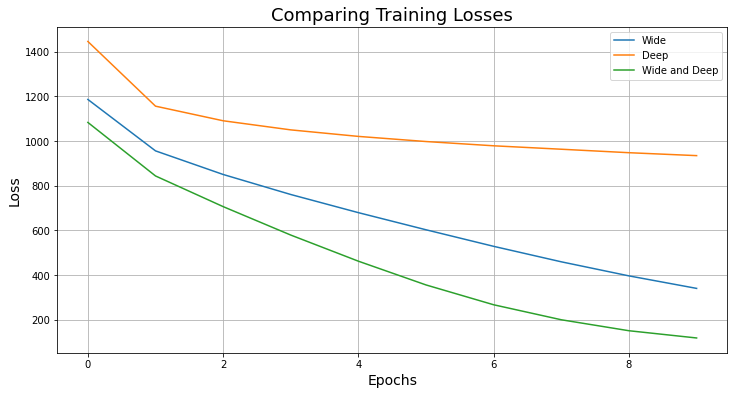

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(epochs, wide_loss, label='Wide')
plt.plot(epochs, deep_loss, label='Deep')
plt.plot(epochs, wide_deep_loss, label='Wide and Deep')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Comparing Training Losses', fontsize=18)
plt.grid(True)
plt.legend()
plt.show()

# Final Comments
- WDNN indeed outperforms both standalone wide and deep NNs on this problem.
- WNNs performance follows roughly the same trend as WDNNs, suggesting that sparse feature vectors have more predictive power on this problem than dense embeddings.
- Difference between WDNN loss and WNN loss sems to grow as the number of epochs increases.
  - This could suggest that the WNN will exhaust its learning capacity before the WDNN. 
- WDNN clearly seems to benefit from the additional predictive power of a DNN component.
- DNN component has the worst performance: clearly, using dense embeddings alone does not seem to be a good approach. 

## Pitfalls
- Difficult to keep track of the order in which inputs have to be fed to the WDNN.
  - Characteristic of all multi-input models.
  - Solution is to specify a `name` for the `Input` tensor of a model.
- Building a WDNN uses up more RAM than any other model I've seen so far.
  - Multiple Google CoLab session crashes because of lack of memory. 
  - Couldn't train WDNN, WNN, DNN in the same session (hence the awkward `pickle` dump/load).
  - Is there a way to fix this?